Shelley's coefficients (for cold temperatures):

$6.1078 \times exp \left( \frac{17.08085 T_a}{234.175 + T_a} \right)$

(Murray, 1967?)

Lawrence:

$610.94 \times exp \left( \frac{17.625 T_a}{243.04 + T_a} \right)$

In [2]:
import sys, re, glob
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs
# from fs.sshfs import SSHFS
# import imp

In [194]:
sys.path.append('../../python/')
from data import IGRA
import plots

In [2]:
# from uv - login with ``ssh uvp`` (remote ssh port forwarding)
sshfs = SSHFS('localhost', 'arno', port=9000)

In [3]:
plots = imp.new_module('plots')
with sshfs.open('/home/arno/Documents/code/python/plots.py') as f:
    exec(f.read(), plots.__dict__)
    
IGRA = imp.new_module('IGRA')
with sshfs.open('/home/arno/Documents/code/python/data/IGRA.py') as f:
    exec(f.read(), IGRA.__dict__)

In [40]:
%matplotlib nbagg

In [6]:
with sshfs.open('/home/arno/Documents/data//IGRA/igra2-station-list.txt') as f:
    ista = IGRA.Monthly.read_stations(f).query('lat<=-60')

In [184]:
ista = IGRA.Monthly.read_stations('../../../data/IGRA/igra2-station-list.txt').query('lat<=-60')

In [304]:
ista.loc[89051]

id            AYM00089051
lat              -63.4667
lon              -56.2833
elev                   18
state                 NaN
name           PETREL NAS
first_year           1969
last_year            1972
nobs                 1654
Name: 89051, dtype: object

In [205]:
ista.loc[89062]

id            AYM00089062
lat              -67.5661
lon              -68.1297
elev                    3
state                 NaN
name              ROTHERA
first_year           2002
last_year            2017
nobs                 2958
Name: 89062, dtype: object

In [206]:
ista.loc[89050]

id               AYM00089050
lat                    -62.2
lon                    -58.9
elev                      16
state                    NaN
name          BELLINGSHAUSEN
first_year              1969
last_year               1999
nobs                   10053
Name: 89050, dtype: object

<IPython.core.display.Javascript object>


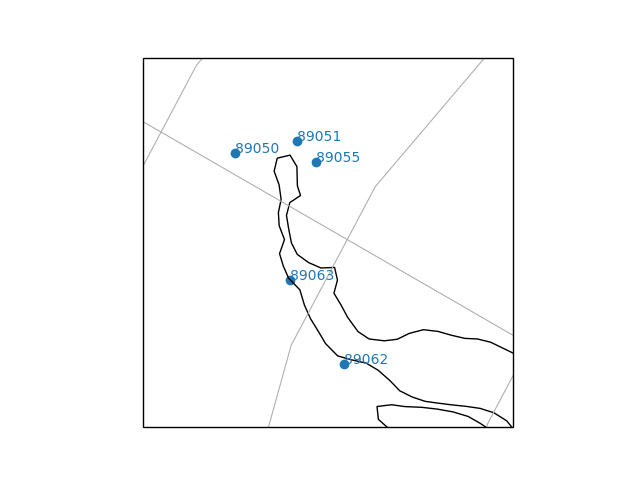

In [303]:
plt.figure()
ax = plt.subplot(1, 1, 1, projection=crs.SouthPolarStereo())
plots.annotated(ista[['lon', 'lat']])

In [112]:
# extract all levels
RH = []
DP = []
for f in glob.glob('data/Antarctica/*-data.txt.zip'):
    n = int(re.search('\d+', f).group())
    d = IGRA.extract(f).reset_index().pivot_table(index='datetime', columns='p')
    d = d[d.index>='1975']
    rh = d['RH'].dropna(0, 'all')
    dp = d['DPDP'].dropna(0, 'all')
    t = d['TEMP'].dropna(0, 'all')
    if rh.shape[0] > 0:
        RH.append((n, rh, t))
    if dp.shape[0] > 0:
        DP.append((n, dp, t))

In [58]:
# extract only the surface records
L = {}
for f in glob.glob('data/Antarctica/*-data.txt.zip'):
    D = {}
    n = int(re.search('\d+', f).group())
    d = IGRA.extract(f).reset_index().pivot_table(index='datetime', columns='p')
    x = d['RH'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int) # note that this produces 0 instead of nan
        D['rh'] = x.sum(1)
        D['p'] = p.sum(1).to_frame()
        
    x = d['DPDP'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int)
        D['dpdp'] = x.sum(1)
        if 'p' in D:
            D['p'] = p.sum(1).to_frame().combine_first(D['p'])
        else:
            D['p'] = p.sum(1).to_frame()
        
    x = d['TEMP'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int)
        D['temp'] = x.sum(1)
        if 'p' in D:
            D['p'] = p.sum(1).to_frame().combine_first(D['p'])
        else:
            D['p'] = p.sum(1).to_frame()
    
    x = d['GPH'][d['LVLTYP2']==1].dropna(1, 'all')
    if x.dropna(0, 'all').any().any():
        p = x.columns.values.reshape((1, -1)) * x.notnull().astype(int)
        D['GPH'] = x.sum(1)
        if 'p' in D:
            D['p'] = p.sum(1).to_frame().combine_first(D['p'])
        else:
            D['p'] = p.sum(1).to_frame()  
    L[n] = pd.concat(D, 1)

In [59]:
n, df = zip(*L.items())

In [21]:
da = IGRA.surface(glob.glob('data/Antarctica/*-data.txt.zip'))

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:29: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif np.issubdtype(dtype, complex):


In [43]:
IGRA.mixing_ratio(da)

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [45]:
da.to_netcdf('data/Antarctica/surface.nc')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/conventions.py:861: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(inferred_dtype, float):


In [85]:
def trim(x):
    x.columns = x.columns.droplevel(1)
    return xr.DataArray(x)

d = xr.concat([trim(x) for x in df], pd.Index(n, name='station'))
ds = d.to_dataset(dim='dim_1')
ds.to_netcdf('data/Antarctica/surface_p_temp_dpdp_rh.nc')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [56]:
import gc
gc.collect()

585

In [115]:
nr, rh, t1 = zip(*RH)
r = xr.concat([xr.DataArray(g) for g in rh], pd.Index(nr, name='station'))
nd, dp, t2 = zip(*DP)
d = xr.concat([xr.DataArray(g) for g in dp], pd.Index(nd, name='station'))

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [116]:
nr

(88968, 89055, 88967, 89009, 89125)

In [117]:
nd

(88968, 89002, 89062, 89055, 89022, 88967, 89009, 89050)

In [128]:
t3 = list(t2)

In [130]:
t3.extend(t1[-1:])

In [132]:
nt = list(nd)

In [134]:
nt.extend(nr[-1:])

In [136]:
t = xr.concat([xr.DataArray(g) for g in t3], pd.Index(nt, name='station'))

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [137]:
ds = xr.Dataset({'rh': r, 'dpdp': d, 'temp': t})
ds.to_netcdf('data/Antarctica/temp_dpdp_rh_stations.nc')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [14]:
def replace_nan(x, value=-8888., fact=0.1):
    v = x.values.copy()
    v[v==value] = np.nan
    return xr.DataArray(v * fact, coords=x.coords)

In [66]:
ds = xr.open_dataset('data/Antarctica/temp_dpdp_rh_stations.nc')

In [8]:
ds = xr.open_dataset('data/Antarctica/surface_p_temp_dpdp_rh_w.nc')

In [110]:
def mixing_ratio(df):
    d = df.reset_index(level='p').replace(-8888., np.nan)
    t = d['TEMP'] / 10.
    p = d['p']

    # dewpoint (dewpoint depression dpdp = temp - dewpt)
    dewp = (t - d['DPDP'] / 10.)

    # vapor pressure (saturation vapor pressure at dewpoint temperature)
    e = 610.94 * np.exp(17.625 * dewp / (243.04 + dewp))

    # mixing ratio
    w_dp = 0.622 * e / (p - e)

    # saturation vapor pressure
    es = 610.94 * np.exp(17.625 * t / (243.04 + t))

    e = es * d['RH'] / 1000 # rh in tenths as everything except pressure

    w_rh = 0.622 * e / (p - e)

    w = pd.concat((p, w_dp, w_rh, d['LVLTYP2']), 1)
    w.columns = ['p', 'dpdp', 'rh', 'LVLTYP2']
    return w.loc[w[['rh', 'dpdp']].notnull().any(1)]

In [59]:
rh = []
for s in w_rh.station:
    t = w_rh.sel(station=s).dropna('datetime').datetime
    if len(t) > 0:
        rh.append((s.item(), len(t), t.values[0], t.values[-1]))
dp = []
for s in w_dp.station:
    t = w_dp.sel(station=s).dropna('datetime').datetime
    if len(t) > 0:
        dp.append((s.item(), len(t), t.values[0], t.values[-1]))

In [61]:
pd.DataFrame(rh)

,0,1,2,3
0,88968,8322,1957-07-01 00:00:00,1985-12-31 12:00:00
1,57401,2138,1957-03-15 18:00:00,1962-11-30 12:00:00
2,89055,4509,1982-07-06 12:00:00,2018-01-17 12:00:00
3,89022,13402,1957-07-01 12:00:00,2018-01-26 12:00:00
4,88967,1660,1970-06-11 00:00:00,1975-07-02 12:00:00
5,89009,25139,1961-01-01 00:00:00,2018-01-26 12:00:00
6,89063,3194,1956-01-01 15:00:00,1972-12-22 12:00:00
7,89125,7616,1957-03-23 03:00:00,1975-01-31 12:00:00
8,89051,1429,1969-03-03 12:00:00,1972-05-14 12:00:00
9,89001,1763,1957-07-01 12:00:00,1972-12-27 00:00:00


In [62]:
pd.DataFrame(dp)

,0,1,2,3
0,88968,8322,1957-07-01 00:00:00,1985-12-31 12:00:00
1,89002,10781,1984-05-03 12:00:00,2017-11-29 12:00:00
2,89062,2934,2002-01-07 12:00:00,2018-01-26 12:00:00
3,89055,4509,1982-07-06 12:00:00,2018-01-17 12:00:00
4,89022,13402,1957-07-01 12:00:00,2018-01-26 12:00:00
5,88967,1660,1970-06-11 00:00:00,1975-07-02 12:00:00
6,89009,25139,1961-01-01 00:00:00,2018-01-26 12:00:00
7,89063,3194,1956-01-01 15:00:00,1972-12-22 12:00:00
8,89125,7616,1957-03-23 03:00:00,1975-01-31 12:00:00
9,89051,1429,1969-03-03 12:00:00,1972-05-14 12:00:00


<IPython.core.display.Javascript object>


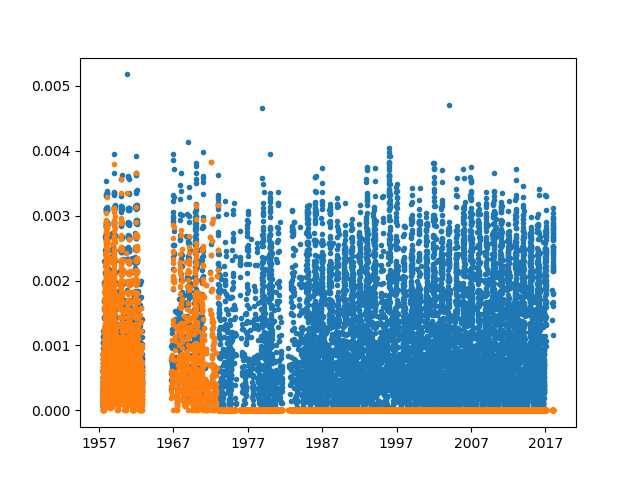

In [96]:
plt.figure()
pl = plt.plot(w_dp.datetime, w_dp.sel(station=89022), '.')
pl = plt.plot(w_rh.datetime, w_rh.sel(station=89022), '.')

<IPython.core.display.Javascript object>


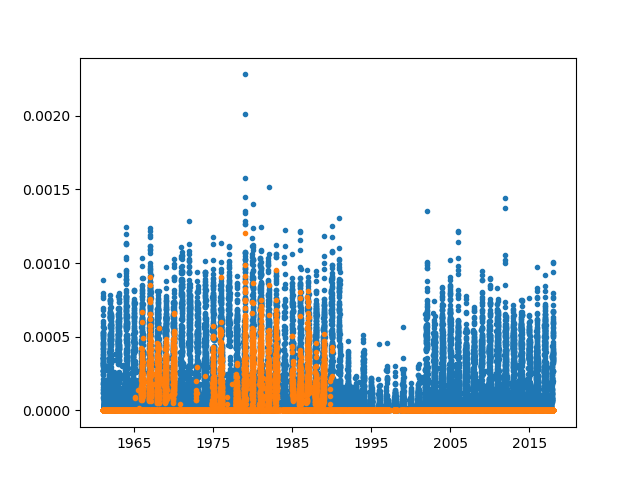

In [97]:
plt.figure()
pl = plt.plot(w_dp.datetime, w_dp.sel(station=89009), '.')
pl = plt.plot(w_rh.datetime, w_rh.sel(station=89009), '.')

In [32]:
def vertint(a):
    b = pd.DataFrame(a.values, index=a.datetime, columns=a.p).fillna(axis=1, method='ffill')
    p = a.p.values.reshape((1, -1)).repeat(len(a.datetime), 0)
    na = a.isnull().values
    p[na] = np.nan
    p = pd.DataFrame(p, index=a.datetime, columns=a.p)
    dp = p.fillna(axis=1, method='ffill').diff(1, 1)
    dp.values[na] = np.nan
    bsum = b.values[:, :-1] + b.values[:, 1:]
    s = np.nansum(dp.values[:, 1:] * bsum, 1) / 2
    return pd.Series(s, index=a.datetime), dp

In [137]:
def vertint(w, mixing_ratio='dpdp', pressure='p'):
    b = w[[pressure, mixing_ratio]].pivot(columns='p')
    na = b.isnull().values
    nb = b.notnull().values
    b.fillna(axis=1, method='ffill', inplace=True)
    p = b.columns.get_level_values('p').values.reshape((1, -1)).repeat(b.shape[0], 0)
    p[na] = np.nan
    p = pd.DataFrame(p, index=b.index, columns=b.columns)
    dp = p.fillna(axis=1, method='ffill').diff(1, 1)
    dp.values[na] = np.nan
    dpv = dp.values[:, 1:]
    bsum = b.values[:, :-1] + b.values[:, 1:]
    s = np.nansum(dpv * bsum, 1) / 2
    
    # some sanity checks
    i = np.isfinite(dpv).sum(1) > 5
    j = np.nanmean(dpv, 1) < 20000
    k = np.nanstd(dpv, 1) < 20000
    
    return pd.Series(s, index=b.index).loc[i * j * k]

## Halley

In [219]:
d = IGRA.Raw('../../../data/Antarctica/AYM00089022-data.txt.zip')

In [220]:
w = d.mixing_ratio()

In [113]:
s, dp = vertint(w)

In [139]:
s2 = vertint(w[w['p']>20000])

/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


<IPython.core.display.Javascript object>


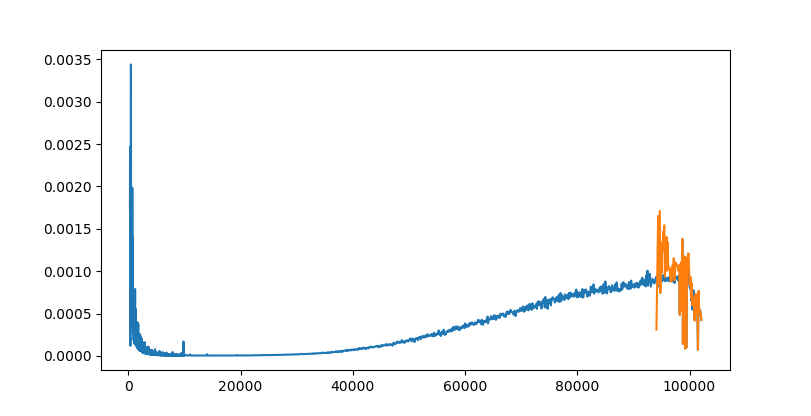

In [114]:
plt.figure()
plt.plot(w.groupby('p').mean()['dpdp'])
plt.plot(w[w['LVLTYP2']==1].groupby('p').mean()['dpdp'])

Mean mixing ratio by pressure - orange are the 'surface level' labeled values. There is clearly a boundary effect from the Magnus-type formula when 0 pressure is approached, hence integration is restricted to below 20000 Pa.

<IPython.core.display.Javascript object>


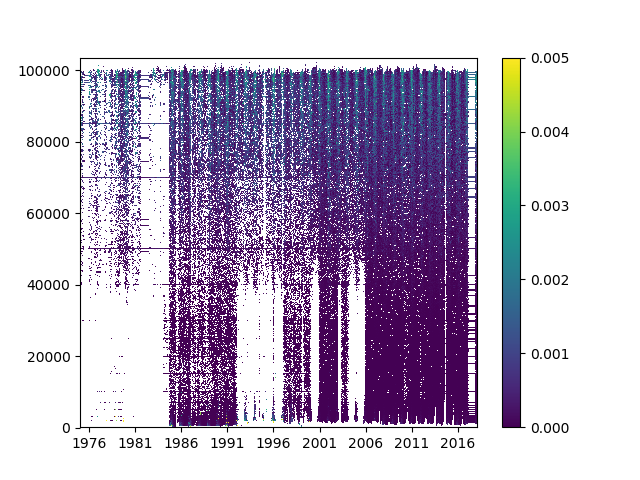

In [100]:
plt.figure()
plt.pcolormesh(a.datetime, a.p, a.T, vmin=0, vmax=.005)
plt.colorbar()

<IPython.core.display.Javascript object>


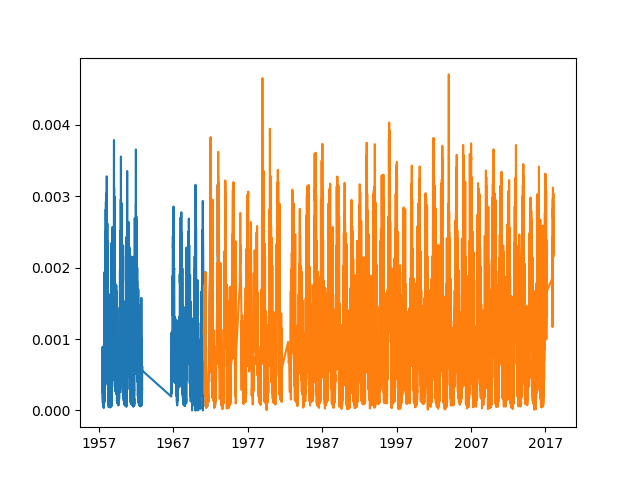

In [52]:
plt.figure()
plt.plot(w_rh.datetime, w_rh)
plt.plot(w_dp.datetime, w_dp)

Surface level - **blue:** from relative humidity ('rh') measurements, **orange:** from dewpoint depression ('dpdp').

<IPython.core.display.Javascript object>


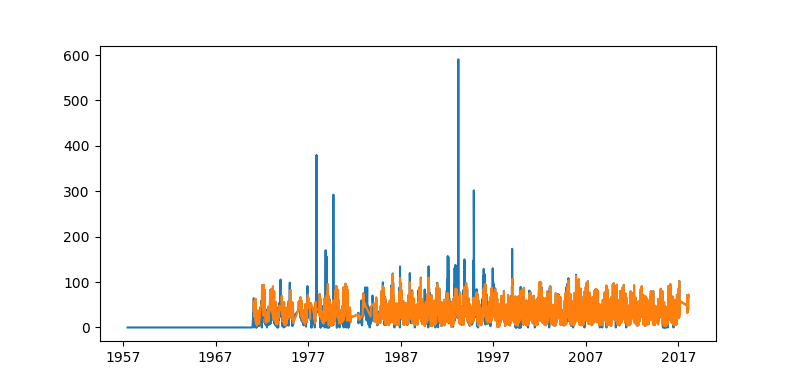

In [140]:
plt.figure()
plt.plot(s)
plt.plot(s2)

**Blue:** integration without any further consideration, **orange:** with sanity checks (below 200 hPa, more than 5 data points in vertical, limits to mean and StDev of $\delta p$ between measurements.

In [221]:
s = d.vertint(w[w['p']>20000])

../../python/data/IGRA.py:124: RuntimeWarning: Mean of empty slice
  j = np.nanmean(dpv, 1) < 20000
../../python/data/IGRA.py:124: RuntimeWarning: invalid value encountered in less
  j = np.nanmean(dpv, 1) < 20000
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../../python/data/IGRA.py:125: RuntimeWarning: invalid value encountered in less
  k = np.nanstd(dpv, 1) < 20000


<IPython.core.display.Javascript object>


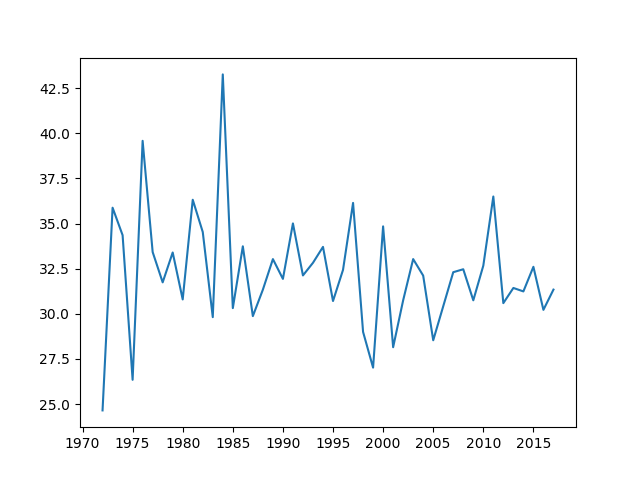

In [144]:
plt.figure()
plt.plot(s2.loc[:'2016'].resample('A').mean())

In [263]:
D = pd.HDFStore('indexes.h5')

In [336]:
D.keys()[:-1]

['/aao_dly',
 '/aao_mly',
 '/nino12',
 '/nino34',
 '/nino34_1870',
 '/nino4',
 '/nino_oni',
 '/nino_tni',
 '/sam_mly']

In [236]:
cc = pd.concat((s.loc[:'2016'].resample('A').mean(), 
           D['nino_oni'].replace(-99.9, np.nan).resample('A').mean()), 1, keys=['data', 0])

In [301]:
def lag(s, delta=np.timedelta64(0), na=-99.9):
    c = s.replace(na, np.nan)
    c.index = s.index + delta
    c.name = delta.astype(int)
    return c

In [341]:
def corr(k):
    cc = pd.concat([lag(D[k], np.timedelta64(n, 'Y')) for n in range(-3, 4)], 1)
    cc = pd.concat((s.loc[:'2016'], cc), 1)
    return cc.resample('A').mean().corr()

In [345]:
keys = ['nino12', 'nino34', 'nino4', 'nino_oni', 'nino_tni']
pd.concat([corr(k)['Halley'] for k in keys], 1, keys=keys).drop('Halley', 0)

,nino12,nino34,nino4,nino_oni,nino_tni
-3,0.016633,0.007720,-0.010686,-0.007573,0.046220
-2,0.073567,0.123683,0.060245,0.135709,0.043018
-1,-0.048404,-0.003667,-0.065185,0.003508,0.016538
0,0.051835,-0.021562,-0.022290,-0.002292,0.080844
1,0.078074,0.094530,0.017676,0.116824,0.109293
2,-0.178139,-0.252590,-0.256874,-0.227366,0.063118
3,-0.018001,0.090847,0.092965,0.124142,-0.100123


In [354]:
cc = pd.concat([lag(D['nino4'], np.timedelta64(n, 'M')) for n in range(-40, 41)], 1)
pd.concat((s.loc[:'2016'], cc), 1).resample('M').mean().corr()['Halley']

Halley    1.000000
-40       0.108529
-39       0.014709
-38      -0.130335
-37      -0.256256
-36      -0.256850
-35      -0.258718
-34      -0.105834
-33      -0.099396
-32       0.047215
-31       0.073767
-30       0.158312
-29       0.174358
-28       0.169840
-27       0.033557
-26      -0.075562
-25      -0.229154
-24      -0.230020
-23      -0.211612
-22      -0.088568
-21      -0.041822
-20       0.052201
-19       0.079767
-18       0.130250
-17       0.161620
-16       0.122661
-15       0.029845
-14      -0.047725
-13      -0.222580
-12      -0.225306
            ...   
11       -0.178356
12       -0.213910
13       -0.200061
14       -0.096962
15       -0.074416
16       -0.002019
17        0.050196
18        0.135034
19        0.132844
20        0.121526
21       -0.025489
22       -0.125185
23       -0.264717
24       -0.236074
25       -0.200983
26       -0.082911
27       -0.054587
28        0.053418
29        0.090014
30        0.137043
31        0.165508
32        0.

In [168]:
d = IGRA.Raw('../../../data/Antarctica/AYM00089009-data.txt.zip')

In [159]:
w = d.mixing_ratio()

In [186]:
s_dp = d.vertint(w[w['p']>20000])
dp_dp = d.dp.copy()
s_rh = d.vertint(w[w['p']>20000], mixing_ratio='rh')
dp_rh = d.dp.copy()

../../python/data/IGRA.py:124: RuntimeWarning: Mean of empty slice
  j = np.nanmean(dpv, 1) < 20000
../../python/data/IGRA.py:124: RuntimeWarning: invalid value encountered in less
  j = np.nanmean(dpv, 1) < 20000
/home/arno/Documents/code/conda/envs/bayes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../../python/data/IGRA.py:125: RuntimeWarning: invalid value encountered in less
  k = np.nanstd(dpv, 1) < 20000


<IPython.core.display.Javascript object>


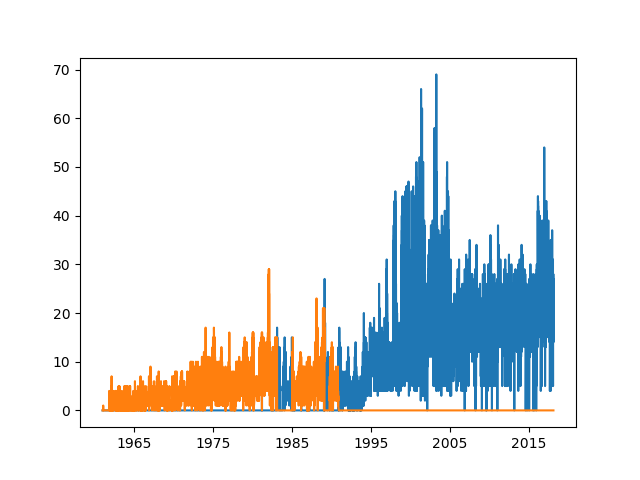

In [190]:
plt.figure()
plt.plot(dp_dp.notnull().sum(1))
plt.plot(dp_rh.notnull().sum(1))

<IPython.core.display.Javascript object>


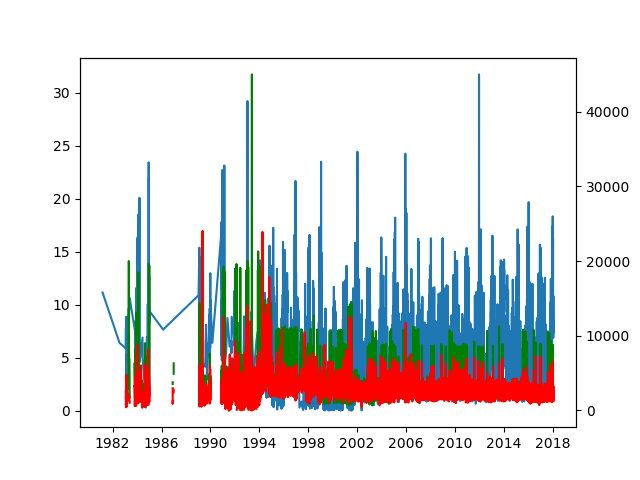

In [171]:
plt.figure()
plt.plot(s)
plt.gca().twinx()
plt.plot(d.dp.mean(1), 'g')
plt.plot(d.dp.std(1), 'r')

<IPython.core.display.Javascript object>


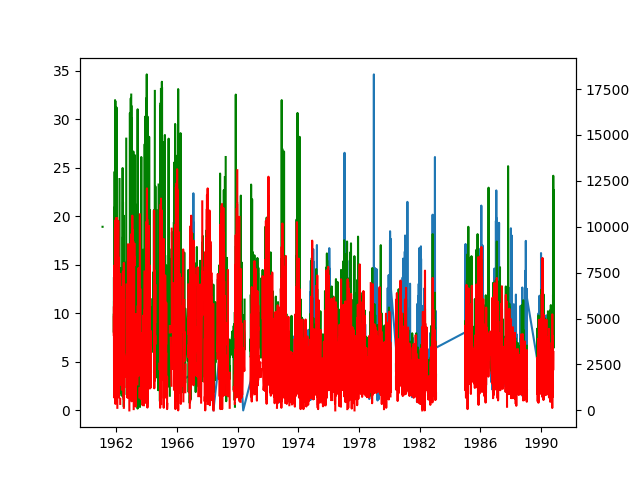

In [180]:
plt.figure()
plt.plot(s)
plt.gca().twinx()
plt.plot(d.dp.mean(1), 'g')
plt.plot(d.dp.std(1), 'r')

<IPython.core.display.Javascript object>


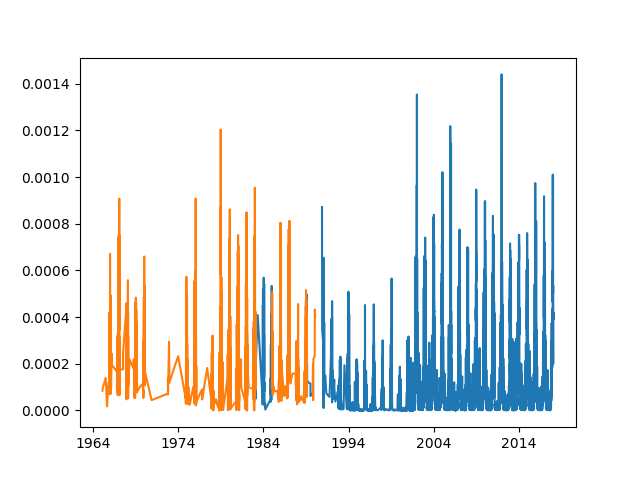

In [185]:
plt.figure()
plt.plot(w[w['LVLTYP2']==1]['dpdp'])
plt.plot(w[w['LVLTYP2']==1]['rh'])

<IPython.core.display.Javascript object>


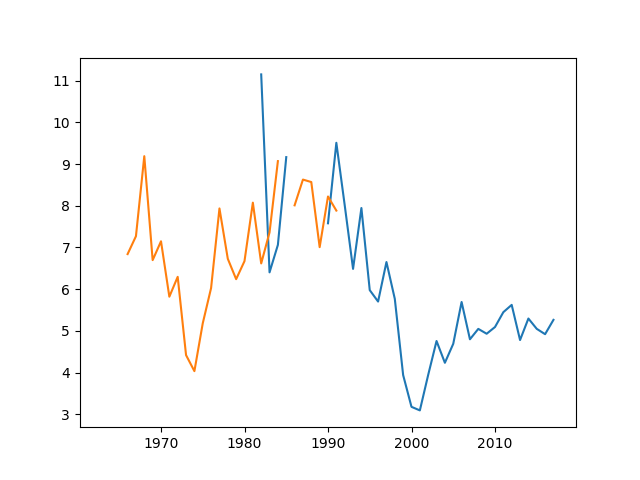

In [191]:
plt.figure()
plt.plot(s_dp.loc[:'2016'].resample('A').mean())
plt.plot(s_rh.loc[:'2016'].resample('A').mean())

In [ ]:
d = IGRA.Raw('../../../data/Antarctica/AYM00089062-data.txt.zip')